In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
from scipy.interpolate import interp1d
from scipy.io import readsav

import re

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy 

from matplotlib.pylab import *
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import NullFormatter

rcParams['figure.figsize'] = (10,8)
rcParams['font.size'] = 22

import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import loadfilt as lf
import igm as lyA
import buildFluxTables as bft

import linecache
import os
import subprocess
import glob
import gc

In [2]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')
logfmt  = FuncFormatter(log_formatter)

def log_GHzFormatter(x,pos):
    return format(np.log10(x)-9.0, '.0f')
logGHzfmt  = FuncFormatter(log_GHzFormatter)

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)

def div_formatter(x,pos):
    return format(x/1000, '.1f')
divfmt  = FuncFormatter(div_formatter)

nullfmt = NullFormatter()
labelsize = 24

In [3]:
# Setup the cosmology used in the runs
# This provides comoving distance, lumin distance, etc... 
cosmo = FlatLambdaCDM(H0=71, Om0=0.267, Ob0=0.0449,name='myCosmo')

In [4]:
cosmo.luminosity_distance(z=1.0)
# Matches Ned's calc: The luminosity distance DL is 6560.5 Mpc or 21.398 Gly. 

<Quantity 6646.699543657951 Mpc>

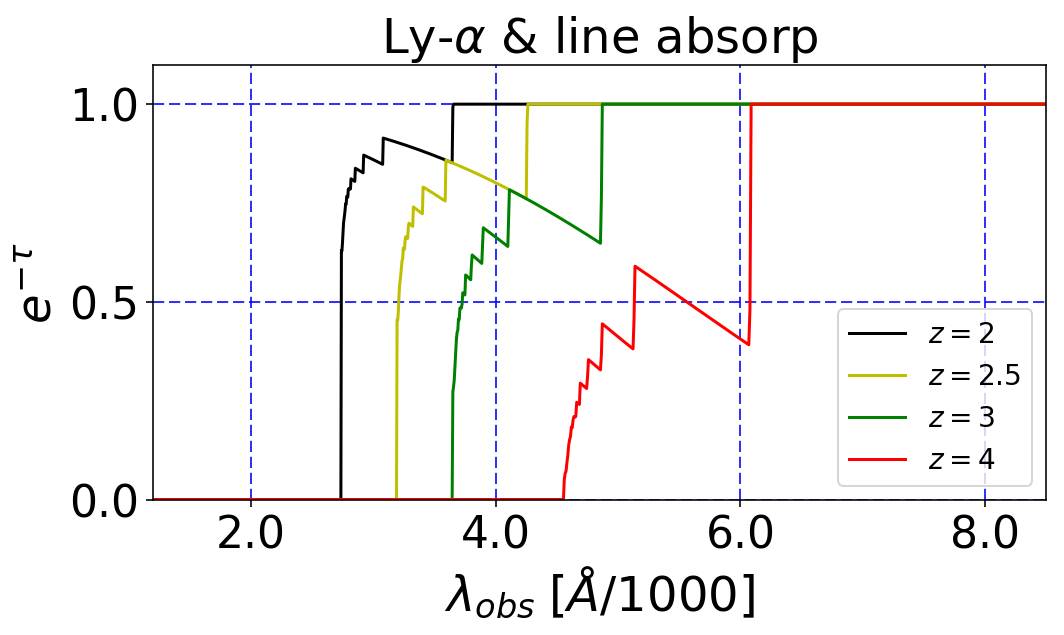

In [32]:
fig = plt.figure(figsize=(8,4))
ax = plt.axes()
lamRange = np.logspace(1.95,5.7,5500)
ax.plot(lamRange,lyA.lyTauC(2.0)(lamRange),'k-',label="$z=2$")
ax.plot(lamRange,lyA.lyTauC(2.5)(lamRange),'y-',label="$z=2.5$")
ax.plot(lamRange,lyA.lyTauC(3)(lamRange),'g-',label="$z=3$")
ax.plot(lamRange,lyA.lyTauC(4)(lamRange),'r-',label="$z=4$")
ax.set_xlim([1200,8500])
ax.set_ylim([1e-9,1.1])
ax.set_ylim([0,1.1])
#ax.set_yscale('log')
ax.set_ylabel(r'$e^{-\tau}$', size=labelsize)
ax.set_xlabel(r'$\lambda_{obs}\; [\AA/1000]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.xaxis.set_major_formatter(divfmt)
ax.set_title(r'Ly-$\alpha$ & line absorp',size=labelsize)
ax.legend(loc=4,fontsize=14)

# Load SB99 data... 

In [7]:
# SB99 format:     TIME [YR]    WAVELENGTH [A]   LOG TOTAL  LOG STELLAR  LOG NEBULAR  [ERG/SEC/A]
# REMEMBER, SB99 data is for a population of 1e6 M_sun
# THIS IS WHY I HAVE "-6" when constructing the flux per wavelen below... 
SB99Path = '/Users/earnric/OneDrive/Software-Models/STARBURST99/STARBURST99-runs/' # Home computer dir... 
SB99Dirs = ['padova0004-op/','padova004-op/','padova008-op/','padova02-op/'] # Dense SED (in age)
Zs       = [0.0004, 0.004, 0.008, 0.02]
SB99FilePat = 'padova*.spectrum1'

# SB99 format:     TIME [YR]    WAVELENGTH [A]   LOG TOTAL  LOG STELLAR  LOG NEBULAR  [ERG/SEC/A]
#                   col 0          col 1           col 2
# NOTE THAT SB99 FLUXES ARE NORMALIZED FOR 1E6 SOLAR MASSES.... WE WANT 1 M_sun: need to subtract
# 6 from the flux values.
for i, (Z, SB99Dir) in enumerate(zip(Zs,SB99Dirs)):
    SB99FilePattern = SB99Path + SB99Dir + SB99FilePat 
    SB99Files   = glob.glob(SB99FilePattern)  # All the files in the dir... should be one!
    if len(SB99Files) != 1:
        print('Error: too many files in an SB99 dir! - ',SB99Path + SB99Dir)
        sys.exit()
    SB99Data    = np.loadtxt(SB99Files[0],skiprows=6)
    if i == 0:
        SB990004 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    elif i == 1:
        SB99004 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    elif i == 2:
        SB99008 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    elif i == 3:
        SB9902 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    # We now have:
    # [[log age, waveln, flux], [], ...]
    # Where flux units are still erg/s/A

In [17]:
np.unique(SB99004[:,0])[0:20]

array([ 4.        ,  5.70757018,  6.00432137,  6.17897695,  6.30319606,
        6.39967372,  6.4785665 ,  6.54530712,  6.60314437,  6.65417654,
        6.69983773,  6.7411516 ,  6.77887447,  6.81358099,  6.84571802,
        6.87563994,  6.90363252,  6.92992956,  6.95472479,  6.97818052])

In [6]:
rsRange = [0.0, 1,0, 2.0,3.0,4.0,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,11.0,12.0,13.0,14.0,15.0,16.0]

In [7]:
## Create a dictionary of observational wavelns and freqs that correspond to 1500A ... 
## Do this for each redshift of interest
rest1500AUV_obsA  = {i: (1500.0 * (1+i))* u.angstrom for i in rsRange}
rest1500AUV_obsHz = {i: (1500.0 * (1+i) * u.angstrom).to(u.Hz, equivalencies=u.spectral()) for i in rsRange}

In [25]:
# Check conversion to Hz from Ang
rest1500AUV_obsHz[2.0],(1500*(1+2) * u.Angstrom).to(u.Hz, equivalencies=u.spectral()),\
rest1500AUV_obsA[2.0],(1+2)*1500

(<Quantity 666205462222222.1 Hz>,
 <Quantity 666205462222222.1 Hz>,
 <Quantity 4500.0 Angstrom>,
 4500)

# Create the UV Flux files... 

Convert redshifted luminosity to flux:
#####  $f_\nu(\nu_o) = \frac{L_\nu(\nu_e)}{4 \pi D_L^2} (1+z)$ 
to account for observed flux at cosmo distances. This is handled in igm.py by rsSEDfreq() or rsSEDwaveln().

Also compute the flux at 10pc so we can compute M_AB later (after summing contributions of galaxy stars).

Note that we do this in the local frame of the star, as noted by BC:
The observer-frame absolute magnitude M [z, t(z)] is the apparent magnitude obtained by assuming dL = 10 pc in equation (6). The *rest-frame absolute magnitude* is the apparent magnitude that the source would have if it were 10 pc away and at rest (i.e., assuming dL = 10 pc and z = 0 in equation [6]). The apparent magnitude in equation (6) can also be computed in terms of the luminosity Lλ(λ,t) emitted by the galaxy per unit wavelength. 

Use 
##### $f_\nu(\nu_o) = \frac{L_\nu(\nu_e)}{4 \pi 10^2}$ 
since we want the * rest frame absolute mag *. Note that 
##### $\nu(\nu_o)=\nu(\nu_e)$
since we are not at cosmological distances.

Lastly, since we are not integrating over a bandpass here, we do NOT need to do the full integral:

## $\frac{\int{\frac{d\nu}{\nu}\frac{L_\nu(\nu_e)}{4 \pi D_L^2} (1+z) \delta(\nu_{1500\unicode{x212B}}-\nu)}}{\int{\frac{d\nu}{\nu}\delta(\nu_{1500\unicode{x212B}}-\nu)}} = \frac{d\nu}{\nu}\frac{L_\nu(\nu_e)}{4 \pi D_L^2} (1+z) \;w/\; \nu_e = \nu_{1500\unicode{x212B}}$

In [42]:
redshifts    = rsRange
redshifts    = [2.0,3.0,4.0,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,11.0,12.0,13.0,14.0,15.0,16.0]
sb99List  = [SB990004, SB99004, SB99008, SB9902]
sb99Names = ["SB990004", "SB99004", "SB99008", "SB9902"]
# sb99List  = [SB9902]
# sb99Names = ["SB9902-TEST"]
hdr = 'LogAge, redshift, 1500_Ang_restFlux, 1500_Ang_10pcFlux'
fmtStr = '%.4f,    %.1f,    %.4e,    %.4e'
print(hdr)
for sb99Data, fname in zip(sb99List,sb99Names):
    print("Working {}".format(fname))
    ages = np.unique(sb99Data[:,0]) # Get the list of UNIQUE log10(ages)
    # Get the log age, wavelength & Luminosity/s/Ang
    allAges = sb99Data[:,0]
    wavelns = sb99Data[:,1] * u.Angstrom
    LperA   = sb99Data[:,2] * u.erg / u.second / u.angstrom
    for z in redshifts:
        prevAge = 0.0
        outfile = []
        print("working {} at z={:.1f}".format(fname,z))
        # Create a lyman forest absorption function for z... ***** NEW truncated absorption
        #######
        absorb = lyA.lyTauC(z) 
        #######
        for age in ages: # Once for each age group in the list
            if age - prevAge < 0.025:
                continue # We don't super-tight spacing in age... 
#             print("Working Age = {:.2e} yr".format(10**age))
            prevAge = age
            ageCond = (allAges == age)
            
            # Select wavelength & Luminosity/Ang based on log age field... work with one
            waveLensAtAge = wavelns[ageCond]
            LperAAtAge    = LperA[ageCond]
            # Restframe SED in freq space: needed for flux at 10 pc
            rfFreq    = (waveLensAtAge[::-1]).to(u.Hz, equivalencies=u.spectral())
            rfLperHz  = ((LperAAtAge * waveLensAtAge**2/astropy.constants.c).to(u.erg/u.s/u.Hz))[::-1]
            # Flux at 10 pc -- used for absolute Mag in rest frame
            rfFperHz  = rfLperHz/( 4.0 * np.pi * ((10.0 * u.pc).to(u.cm))**2)

            # Redshift the SED luminosity to get flux, Do Lyman forest/continuum absorption 
            rsWaveln, rsFluxperA  = lyA.rsSEDwavelen(waveLensAtAge, LperAAtAge, z) # Redshift SED in wavelen
            lymanForFluxA         = rsFluxperA * u.erg/u.s/u.angstrom/u.cm**2 * absorb(rsWaveln) # Absorption
            
            # Convert to freq & Lumin/s/Hz, reverse order so we go from low to high Hz
            rsFreq         = (rsWaveln[::-1]).to(u.Hz, equivalencies=u.spectral())
            lymanForFluxHz = ((lymanForFluxA * rsWaveln**2/astropy.constants.c).to(u.erg/u.s/u.Hz/u.cm**2))[::-1]
            
            # Create a flux (erg/s/Hz/cm^2) function so we can get value at exactly 1500A
            fluxAtRedshift = interp1d(rsFreq,lymanForFluxHz,kind='linear')
            uvFlux = fluxAtRedshift(rest1500AUV_obsHz[z].value) # Flux at 1500A
            
            # Flux at 10 pc
            fluxInRF = interp1d(rfFreq,rfFperHz,kind='linear')
            fluxAt10 = fluxInRF(rest1500AUV_obsHz[0].value)
            
            aLine = [age] + [z] + [uvFlux] + [fluxAt10]
            outfile.append(aLine)
        filename = fname + "_UV_" + str(z) + ".gz"
        print('writing {}'.format(filename))
        np.savetxt(filename, outfile, fmt=fmtStr, delimiter=', ', header=hdr)

LogAge, redshift, 1500_Ang_restFlux, 1500_Ang_10pcFlux
Working SB990004
working SB990004 at z=2.0
writing SB990004_UV_2.0.gz
working SB990004 at z=3.0
writing SB990004_UV_3.0.gz
working SB990004 at z=4.0
writing SB990004_UV_4.0.gz
working SB990004 at z=5.0
writing SB990004_UV_5.0.gz
working SB990004 at z=5.5
writing SB990004_UV_5.5.gz
working SB990004 at z=6.0
writing SB990004_UV_6.0.gz
working SB990004 at z=6.5
writing SB990004_UV_6.5.gz
working SB990004 at z=7.0
writing SB990004_UV_7.0.gz
working SB990004 at z=7.5
writing SB990004_UV_7.5.gz
working SB990004 at z=8.0
writing SB990004_UV_8.0.gz
working SB990004 at z=8.5
writing SB990004_UV_8.5.gz
working SB990004 at z=9.0
writing SB990004_UV_9.0.gz
working SB990004 at z=9.5
writing SB990004_UV_9.5.gz
working SB990004 at z=10.0
writing SB990004_UV_10.0.gz
working SB990004 at z=11.0
writing SB990004_UV_11.0.gz
working SB990004 at z=12.0
writing SB990004_UV_12.0.gz
working SB990004 at z=13.0
writing SB990004_UV_13.0.gz
working SB990004 at

Look at absorption in Hz an Ang... for z=2 ... check

In [87]:
rsWaveln[-1],rsFreq[0], rest1500AUV_obsHz[z].to(u.THz)

(<Quantity 4800000.0 Angstrom>,
 <Quantity 624567620833.3333 Hz>,
 <Quantity 666.2054622222221 THz>)

In [79]:
(astropy.constants.c/(4800000.0 * u.angstrom) ).to(u.Hz)

<Quantity 624567620833.3331 Hz>

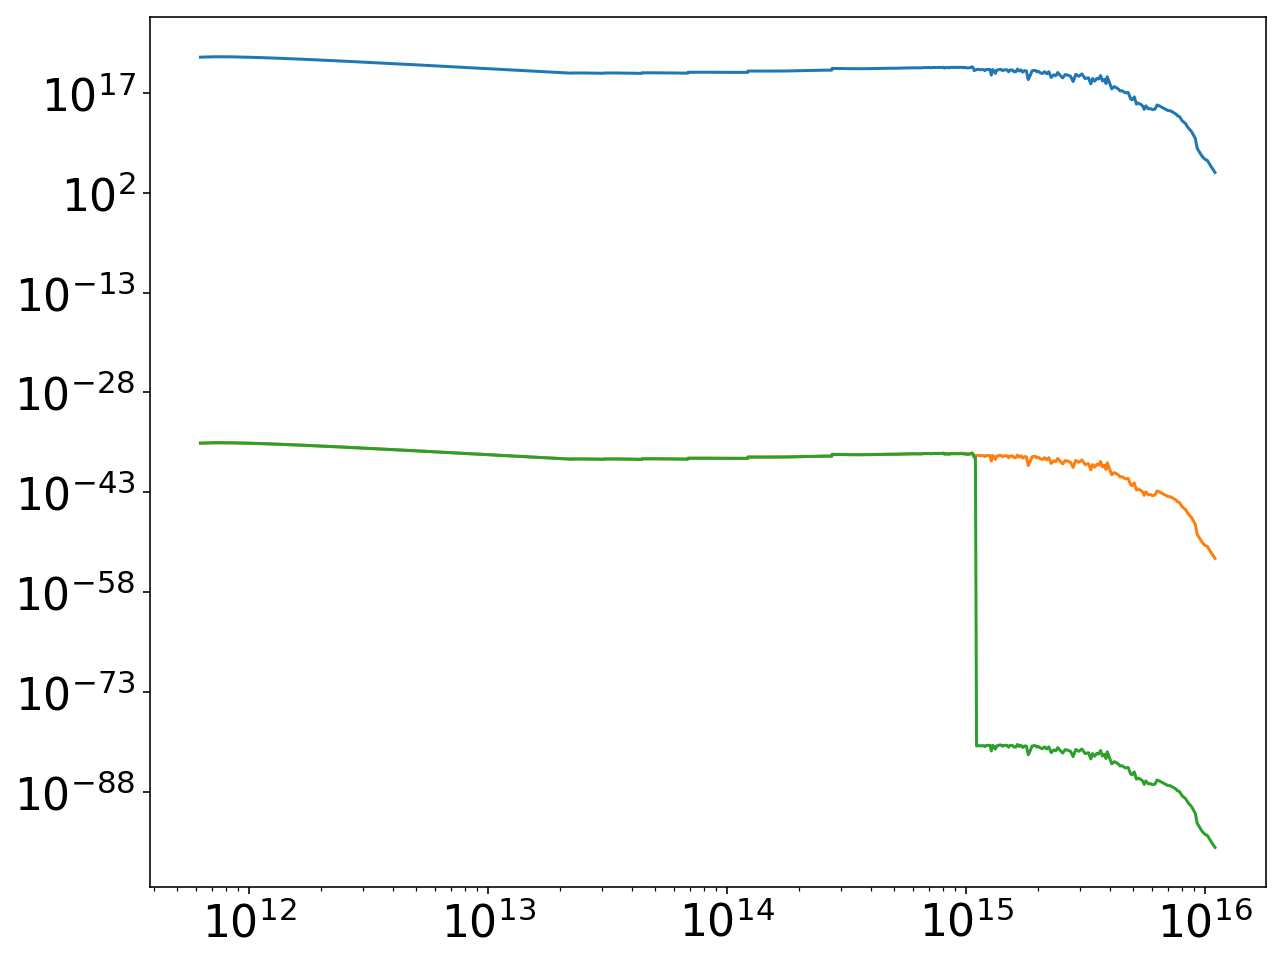

In [83]:
plt.loglog(freq, LperHz)
rsFluxperAUnits = rsFluxperA * u.erg/u.s/u.angstrom/u.cm**2
plt.loglog(rsFreq,  ((rsFluxperAUnits * rsWaveln**2/astropy.constants.c).to(u.erg/u.s/u.Hz/u.cm**2))[::-1])
plt.loglog(rsFreq,  lymanForFluxHz)

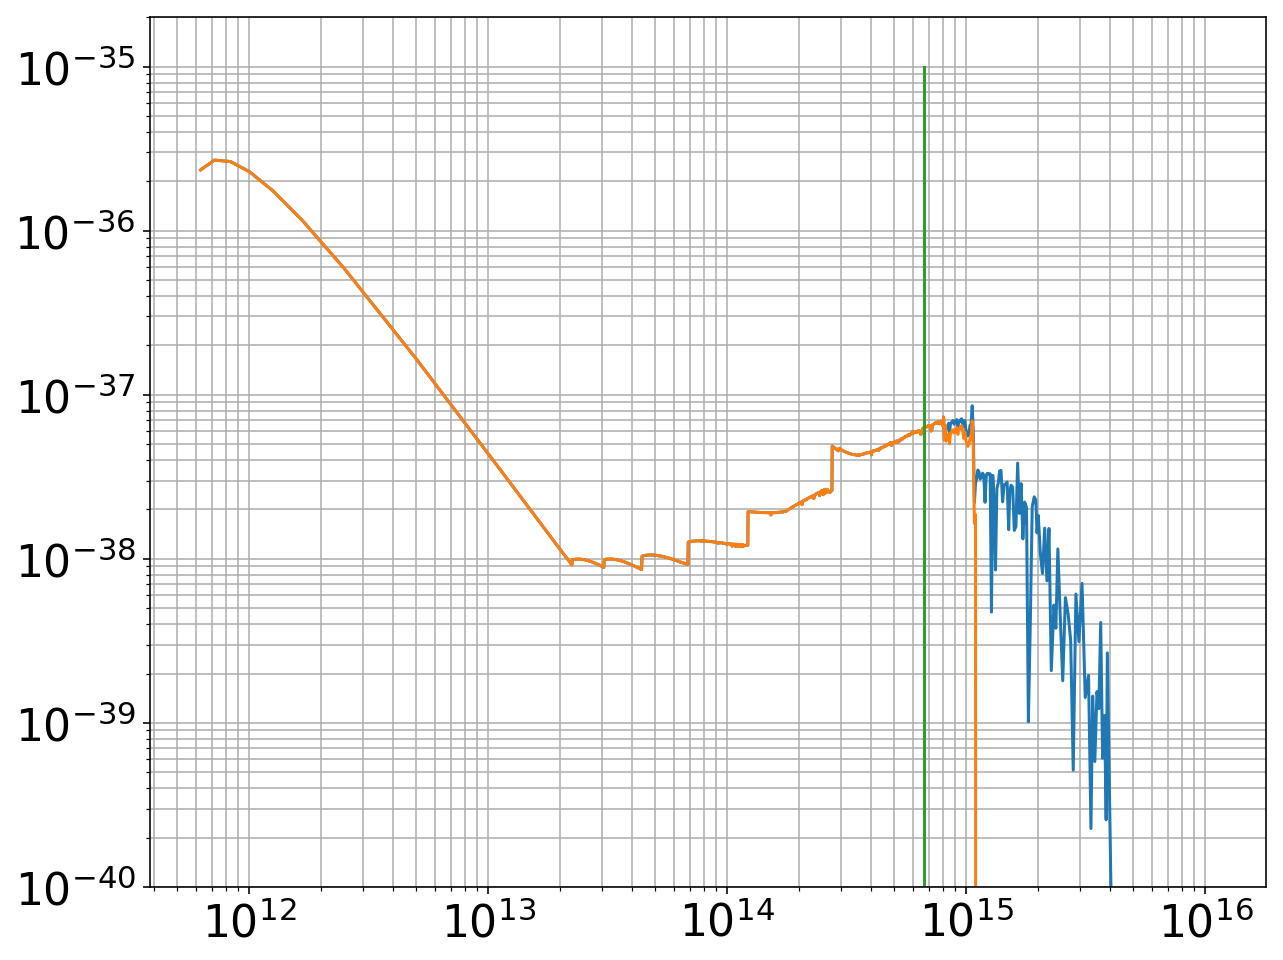

In [88]:
plt.loglog(rsFreq,  ((rsFluxperAUnits * rsWaveln**2/astropy.constants.c).to(u.erg/u.s/u.Hz/u.cm**2))[::-1])
plt.loglog(rsFreq,  lymanForFluxHz)
plt.plot((rest1500AUV_obsHz[z].value, rest1500AUV_obsHz[z].value),(1e-40,1e-35))
plt.ylim([1e-40,2e-35])
plt.grid(which='both')

In [93]:
absorb(500)

array(3.715290076495727e-44)

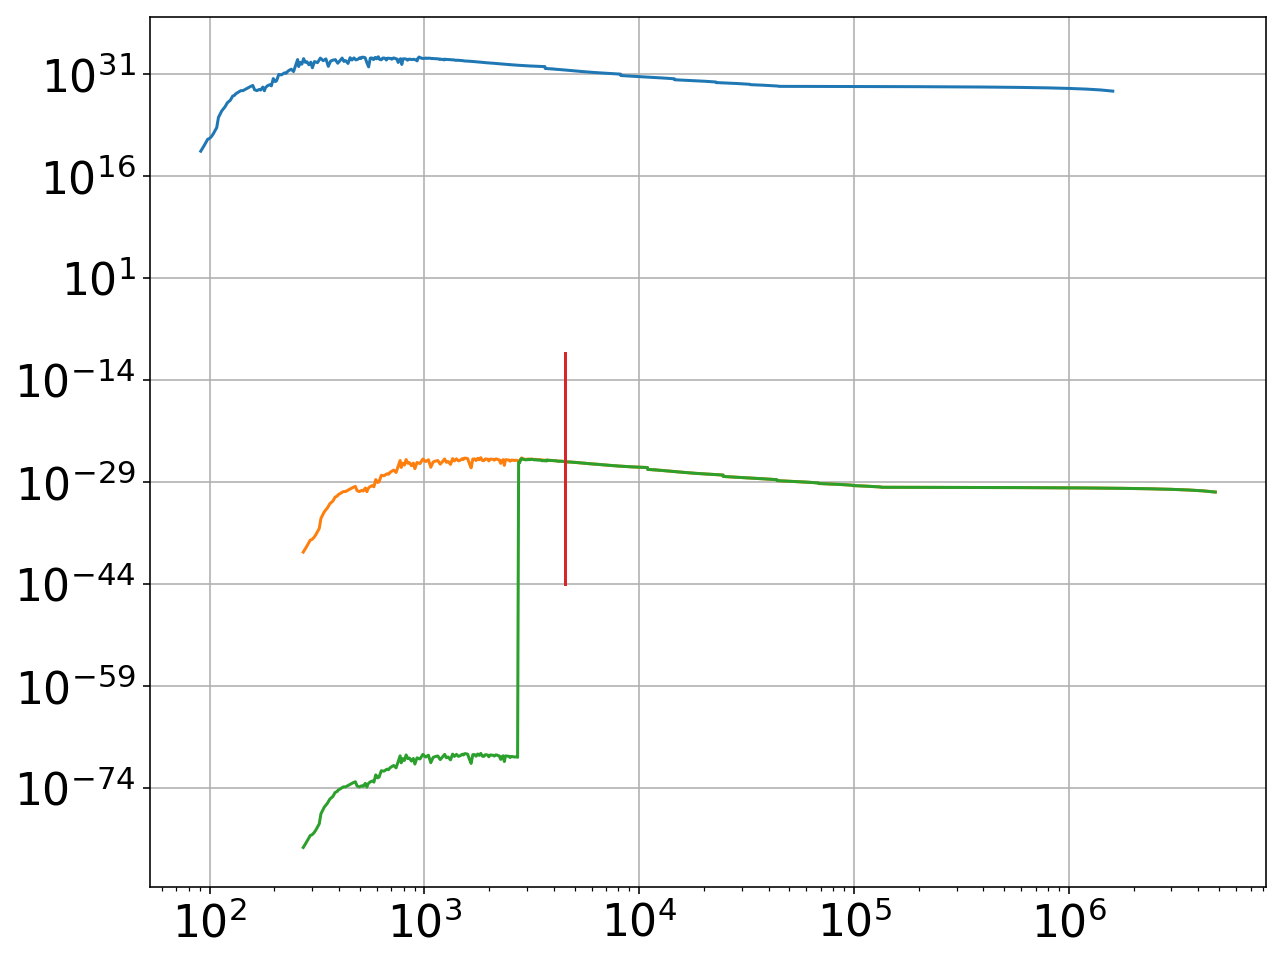

In [92]:
plt.loglog(wavelns[ageCond], LperA[ageCond])
plt.loglog(rsWaveln, rsFluxperA)
plt.loglog(rsWaveln,(rsFluxperA * absorb(rsWaveln)))
plt.plot((1500*(1+z),1500*(1+z)),(1e-44,1e-10))
plt.grid()

In [21]:
np.power(10,[6.0043,6.179,6.3032])

array([ 1009950.29412032,  1510080.15416415,  2010018.24711369])

# Schaerer

In [38]:
gc.collect()

8429

In [39]:
# jwstFilters   = lf.loadJWSTFilters(suppress=True)
# hubbleFilters = lf.loadHubbleFilters(suppress=True)
# jhkFilters    = lf.loadJHKFilters(suppress=True)

lamRange      = np.logspace(1.95,5.7,5500)

schaererPath = '/Users/earnric/Research/Research-Observability/Software-Models/Schaerer/'
schaererDirs = ['pop3_TA/','pop3_TE/','e-70_mar08/','e-50_mar08/']
# schaererDirs = ['pop3_TAtest/']
Zs           = [0.0, 0.0, 1.0e-7, 1.0e-5]
schaererPopFilePattern  = 'pop3_ge0_log?_500_001_is5.[0-9]*' # is5 files have ages in step of 1 Myr
schaererLowZFilePattern = 'e-?0_sal_100_001_is2.[0-9]*'      # is2 files have ages in step of 0.05 dex

# Load the schaerer files... 
# Note that due to spacing (in age), there are sometimes two files that 
# are SEDS for the same time-stamp! Skip the second one (and third!)
lastAge = 0.0
for i, (Z, schaererDir) in enumerate(zip(Zs,schaererDirs)):
    if schaererDir.startswith('pop3'):
        schaererFilePattern = schaererPath + schaererDir + schaererPopFilePattern  # Pop III files, 1 Myr spacing
    else:
        schaererFilePattern = schaererPath + schaererDir + schaererLowZFilePattern # Low Z files, 0.05 dex spacing

    schaererFiles   = glob.glob(schaererFilePattern)  # All the files in the dir... 
    schaererFiles   = [a for a in schaererFiles if not re.search('\.[1-2][0-9][b]*$', a)] # remove .1? and .2? files
    schaererAges    = [linecache.getline(file,13) for file in schaererFiles]    # Get the line with the (log) age... 
    schaererAges    = np.array([float(sa[30:]) for sa in schaererAges],dtype=float)         # Log age starts at position 30

    schaererData    = np.array([np.loadtxt(file,skiprows=16) for file in schaererFiles])
    ageSortIndxes   = schaererAges.argsort()          # Array of indices to sort things by age...
    
    schaererData    = schaererData[ageSortIndxes]
    schaererAges    = schaererAges[ageSortIndxes]
    print(len(schaererAges),schaererAges)

    # Ignore data files with the same age! This occurs in the popIII dirs
    # because the timestep is smaller than the age-resolution printed in the file
    # Hence we get 2 files with different data but the same time stamp
    lastAge = 0.0
    schaererDataGood = []
    schaererAgesGood = []
    for ii,(sd,age) in enumerate(zip(schaererData,schaererAges)):
        if age == lastAge:
            # Remove it
            continue
        lastAge = age
        schaererDataGood.append(sd)
        schaererAgesGood.append(float(age))
    
    # The following builds an array of arrays (one for each age) with each array's entries:
    # log age, Z, waveln, lum/A
    allSchaererData = [np.insert(sed[:,[0,2]],[0],[[anAge] for ii in range(0,len(sed))], axis=1) 
        for anAge,sed in zip(schaererAgesGood, schaererDataGood)]
    allSchaererData = np.array(allSchaererData).reshape(len(allSchaererData)*len(allSchaererData[0]),3)
    if i == 0:
        pop3TA = allSchaererData # may need a np.copy(...) here... ??
    elif i == 1:
        pop3TE = allSchaererData
    elif i == 2:
        Zem7 = allSchaererData
    elif i == 3:
        Zem5 = allSchaererData
    # We now have:
    # [[log age, waveln, flux], [], ...]

1001 [ 4.     6.004  6.303 ...,  8.999  9.     9.   ]
1001 [ 4.     6.004  6.303 ...,  8.999  9.     9.   ]
112 [ 4.    4.05  4.1   4.15  4.2   4.25  4.3   4.35  4.4   4.45  4.5   4.55
  4.6   4.65  4.7   4.75  4.8   4.85  4.9   4.95  5.    5.05  5.1   5.15
  5.2   5.25  5.3   5.35  5.4   5.45  5.5   5.55  5.6   5.65  5.7   5.75
  5.8   5.85  5.9   5.95  6.    6.05  6.1   6.15  6.2   6.25  6.3   6.35
  6.4   6.45  6.5   6.55  6.6   6.65  6.7   6.75  6.8   6.85  6.9   6.95
  7.    7.05  7.1   7.15  7.2   7.25  7.3   7.35  7.4   7.45  7.5   7.55
  7.6   7.65  7.7   7.75  7.8   7.85  7.9   7.95  8.    8.05  8.1   8.15
  8.2   8.25  8.3   8.35  8.4   8.45  8.5   8.55  8.6   8.65  8.7   8.75
  8.8   8.85  8.9   8.95  9.    9.05  9.1   9.15  9.2   9.25  9.3   9.35
  9.4   9.45  9.5   9.55]
114 [ 4.    4.05  4.1   4.15  4.2   4.25  4.3   4.35  4.4   4.45  4.5   4.55
  4.6   4.65  4.7   4.75  4.8   4.85  4.9   4.95  5.    5.05  5.1   5.15
  5.2   5.25  5.3   5.35  5.4   5.45  5.5   5.55  5.6  

In [82]:
gc.collect()

6

In [43]:
redshifts    = [2.0,3.0,4.0,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,11.0,12.0,13.0,14.0,15.0,16.0]
# redshifts    = [2.0]
schaererList = [pop3TA, pop3TE, Zem7, Zem5]
schaererNames = ["pop3TA", "pop3TE", "Zem7", "Zem5"]
# schaererList = [pop3TA]
# schaererNames = ["pop3TA_TEST"]
hdr = 'LogAge, redshift, 1500_Ang_restFlux, 1500_Ang_10pcFlux'
fmtStr = '%.4f,    %.1f,    %.4e,    %.4e'
print(hdr)
for schaererData, fname in zip(schaererList,schaererNames):
    print("Working on file {}".format(fname))
    ages = np.unique(schaererData[:,0]) # Get the list of ages
    ages = ages[ages <= 9.01] # We don't need flux for stars older than 1.02 Gyr
    # Get the log age, wavelength & Luminosity/s/Ang
    allAges = schaererData[:,0]
    wavelns = schaererData[:,1] * u.Angstrom
    LperA   = schaererData[:,2] * u.erg / u.second / u.angstrom
    for z in redshifts:
        prevAge = 0.0
        outfile = []
        print("working {} at z={:.1f}".format(fname,z))
        absorb = lyA.lyTauC(z) # Create a lyman forest absorption function for z... # NEW Truncated absorption
        for age in ages: # Once for each age group in the list
            if age - prevAge < 0.025:
                continue # We don't super-tight spacing in age... 
#             print("log age={:.4f}".format(age))
            prevAge = age
            ageCond = (allAges == age) # select records based on log age field... 
            
            # Select wavelength & Luminosity/Ang based on log age field... work with one
            waveLensAtAge = wavelns[ageCond]
            LperAAtAge    = LperA[ageCond]
            
            # Restframe SED in freq space: needed for flux at 10 pc
            rfFreq    = (waveLensAtAge[::-1]).to(u.Hz, equivalencies=u.spectral())
            rfLperHz  = ((LperAAtAge * waveLensAtAge**2/astropy.constants.c).to(u.erg/u.s/u.Hz))[::-1]
            # Flux at 10 pc -- used for absolute Mag in rest frame
            rfFperHz  = rfLperHz/( 4.0 * np.pi * ((10.0 * u.pc).to(u.cm))**2)

            # Redshift the SED luminosity to get flux, Do Lyman forest/continuum absorption 
            rsWaveln, rsFluxperA  = lyA.rsSEDwavelen(waveLensAtAge, LperAAtAge, z) # Redshift SED in wavelen
            lymanForFluxA         = rsFluxperA * u.erg/u.s/u.angstrom/u.cm**2 * absorb(rsWaveln) # Absorption
            
            # Convert to freq & Lumin/s/Hz, reverse order so we go from low to high Hz
            rsFreq         = (rsWaveln[::-1]).to(u.Hz, equivalencies=u.spectral())
            lymanForFluxHz = ((lymanForFluxA * rsWaveln**2/astropy.constants.c).to(u.erg/u.s/u.Hz/u.cm**2))[::-1]
            
            # Create a flux (erg/s/Hz/cm^2) function so we can get value at exactly 1500A
            fluxAtRedshift = interp1d(rsFreq,lymanForFluxHz,kind='linear')
            uvFlux = fluxAtRedshift(rest1500AUV_obsHz[z].value) # Flux at 1500A
            
            fluxInRF = interp1d(rfFreq,rfFperHz,kind='linear')
            fluxAt10 = fluxInRF(rest1500AUV_obsHz[0].value)

            aLine = [age] + [z] + [uvFlux] + [fluxAt10]
            outfile.append(aLine)
        filename = fname + "_UV_" + str(z) + ".gz"
        print('writing {}'.format(filename))
        np.savetxt(filename, outfile, fmt=fmtStr, delimiter=', ', header=hdr)

LogAge, redshift, 1500_Ang_restFlux, 1500_Ang_10pcFlux
Working on file pop3TA
working pop3TA at z=2.0
writing pop3TA_UV_2.0.gz
working pop3TA at z=3.0
writing pop3TA_UV_3.0.gz
working pop3TA at z=4.0
writing pop3TA_UV_4.0.gz
working pop3TA at z=5.0
writing pop3TA_UV_5.0.gz
working pop3TA at z=5.5
writing pop3TA_UV_5.5.gz
working pop3TA at z=6.0
writing pop3TA_UV_6.0.gz
working pop3TA at z=6.5
writing pop3TA_UV_6.5.gz
working pop3TA at z=7.0
writing pop3TA_UV_7.0.gz
working pop3TA at z=7.5
writing pop3TA_UV_7.5.gz
working pop3TA at z=8.0
writing pop3TA_UV_8.0.gz
working pop3TA at z=8.5
writing pop3TA_UV_8.5.gz
working pop3TA at z=9.0
writing pop3TA_UV_9.0.gz
working pop3TA at z=9.5
writing pop3TA_UV_9.5.gz
working pop3TA at z=10.0
writing pop3TA_UV_10.0.gz
working pop3TA at z=11.0
writing pop3TA_UV_11.0.gz
working pop3TA at z=12.0
writing pop3TA_UV_12.0.gz
working pop3TA at z=13.0
writing pop3TA_UV_13.0.gz
working pop3TA at z=14.0
writing pop3TA_UV_14.0.gz
working pop3TA at z=15.0
writi

## 

In [97]:
# Check out lyman absorption trick above (using wavelen array in reverse to get absorption values for freq!)
lyForFluxA = (rsFluxperA * absorb(rsWaveln))
lyForNewFluxHz = (lyForFluxA * u.erg/u.s/u.angstrom/u.cm**2 * rsWaveln**2/astropy.constants.c).to(u.erg/u.s/u.Hz/u.cm**2)[::-1]

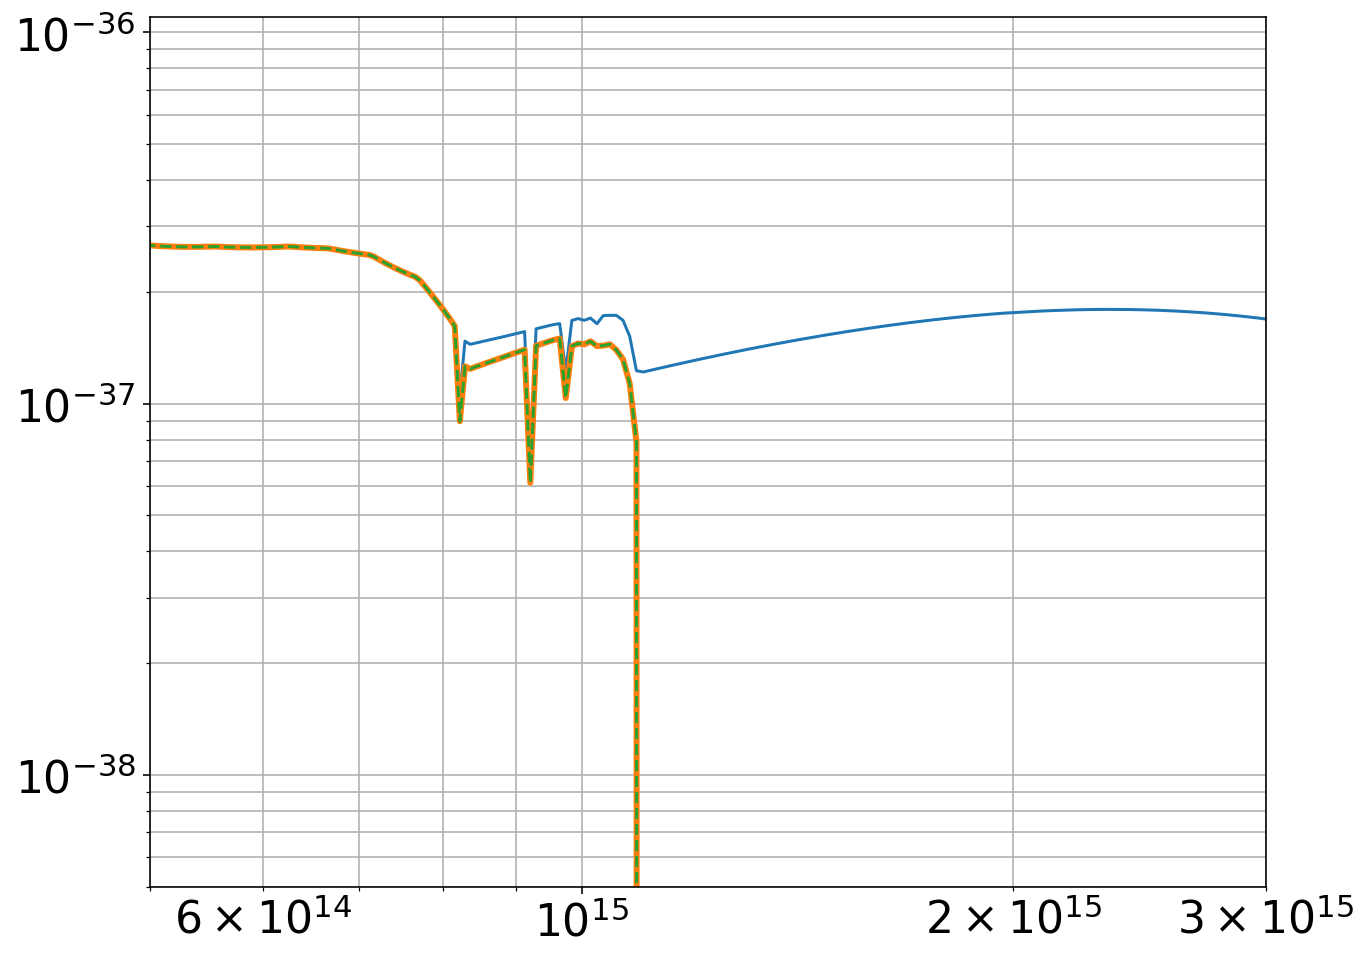

In [106]:
plt.loglog(rsFreq,  rsLperHz)
plt.loglog(rsFreq,  lyForFluxHz,lw=3)
plt.loglog(rsFreq,  lyForNewFluxHz,'--')
plt.xlim([5e14,3e15])
plt.ylim([5e-39,1.1e-36])
plt.grid(which='both')

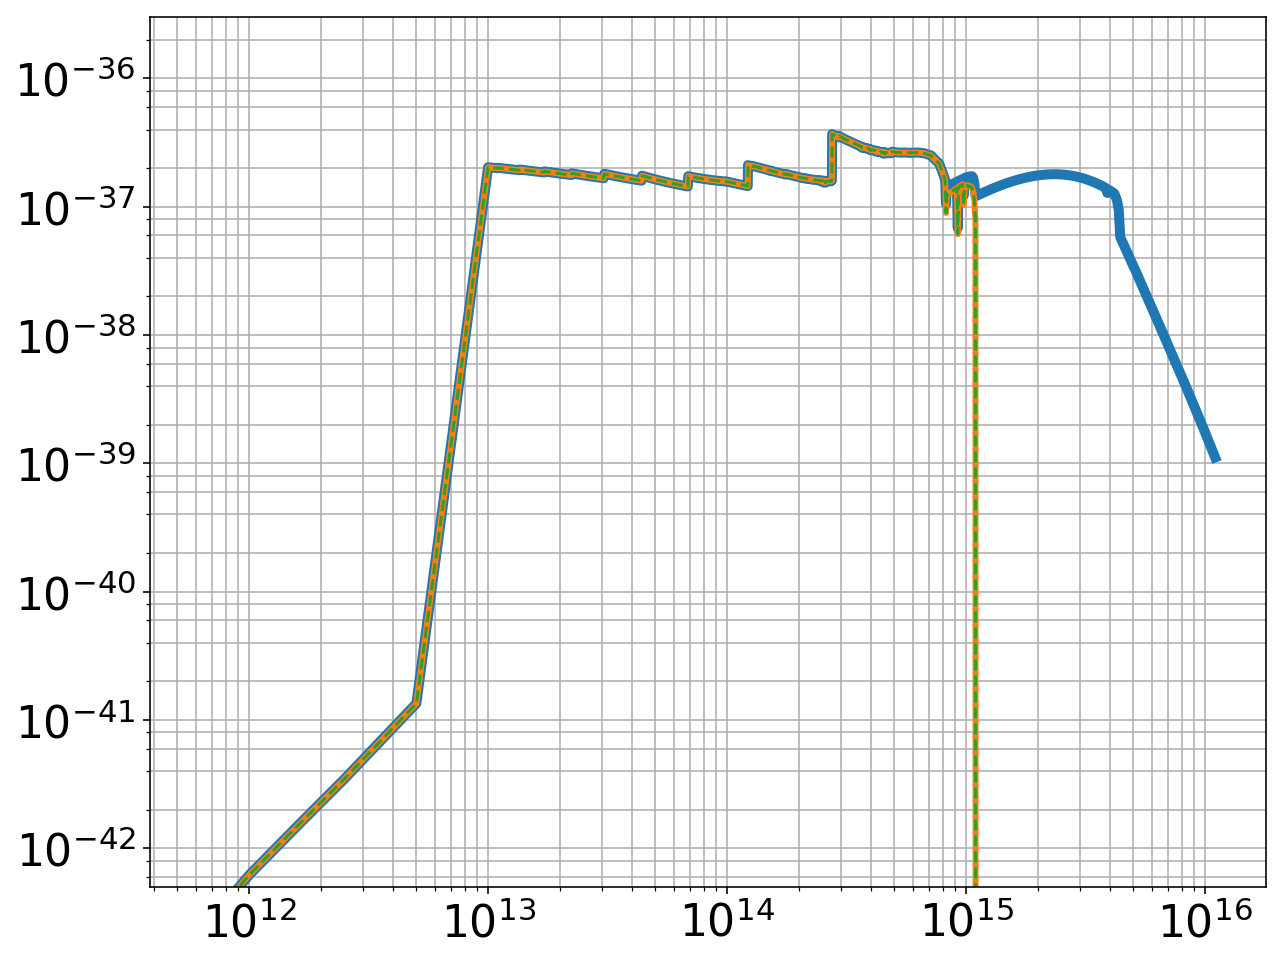

In [109]:
plt.loglog(rsFreq,  rsLperHz,lw=5)
plt.loglog(rsFreq,  lyForFluxHz,lw=3)
plt.loglog(rsFreq,  lyForNewFluxHz,'--')
# plt.xlim([5e14,3e15])
plt.ylim([5e-43,3e-36])
plt.grid(which='both')